### The goal of this notebook is to display photos
(In whatever form)

Of 100 mergers from TNG100.

Since there are available images at z = 0.05, this could be a good place to search.

Since there isn't a next progenitor pointer in the normal snapshot files, you'll have to use the merger trees.
And it would be great if you could use the same architecture as TNG50 so that it could transfer over better.



In [ ]:
# Sublink merger trees are located:
# TNG100-1/postprocessing/trees/SubLink/tree_extended.*.hdf5
# You will also need the group files in order to access portions of the tree, so get that first

In [1]:
# This is different from the api so you will need to set up some things locally:
# follow the directions here:

# cd ~
# mkdir Illustris
# cd Illustris
# git clone https://github.com/illustristng/illustris_python.git
# export PYTHONPATH=~/Illustris/illustris_python

# Make a home for your offset catalogs, which are different from the group catalogs:
# Also, this is different from Illustris

# mkdir -p ~/Illustris/TNG100-1/postprocessing/offsets/
# cd ~/Illustris/TNG100-1/postprocessing/offsets/
# wget --content-disposition --header="API-Key: 3b865713af85f5da0dba3b577e289484" "http://www.tng-project.org/api/TNG100-1/files/offsets.99.hdf5"

# Then get your group catalogs:
# mkdir -p ~/Illustris/TNG100-1/ouptut/groups_099
# cd ~/Illustris/TNG100-1/output/groups_099/
# wget -nd -nc -nv -e robots=off -l 1 -r -A hdf5 --content-disposition --header="API-Key: 3b865713af85f5da0dba3b577e289484" "http://www.tng-project.org/api/TNG100-1/files/groupcat-099/?format=api"




In [2]:
# I'm guessing that if I want to do this directly, I can simply set the basepath to the actual location
# and then everything's already there!

In [11]:
# Set everything up:
import illustris_python as il
import matplotlib.pyplot as plt
import numpy as np

basePath = '/Users/beckynevin/Illustris/TNG100-1/output'
fields = ['SubhaloMass','SubhaloSFRinRad','SubhaloIDMostbound']
subhalos = il.groupcat.loadSubhalos(basePath,99,fields=fields)
subhalos.keys()

dict_keys(['count', 'SubhaloMass', 'SubhaloSFRinRad', 'SubhaloIDMostbound'])

Text(0, 0.5, 'Star Formation Rate [$M_\\odot / yr$]')

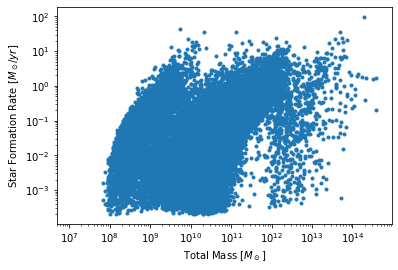

In [12]:
# The group catalogs look like they are useful for various properties at a given snapnum:
# i.e., mass:
mass_msun = subhalos['SubhaloMass'] * 1e10 / 0.704

plt.plot(mass_msun,subhalos['SubhaloSFRinRad'],'.')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Total Mass [$M_\odot$]')
plt.ylabel('Star Formation Rate [$M_\odot / yr$]')

In [14]:
# Print the subhalo IDs
print(len(subhalos['SubhaloIDMostbound']),subhalos['SubhaloIDMostbound'] )

4371211 [120025224909 108587636843 120540440646 ...   6027826629   6027762537
   6028503637]


In [15]:
# Get the primary subhalo IDs by loading the GroupFirstSub field from FOF:
GroupFirstSub = il.groupcat.loadHalos(basePath,99,fields=['GroupFirstSub'])

In [4]:
# Now get the full merger tree

# mkdir -p ~/Illustris/TNG100-1/postprocessing/trees/SubLink
# cd ~/Illustris/TNG100-1/postprocessing/trees/SubLink/
# wget -nd -nc -nv -e robots=off -l 1 -r -A hdf5 --content-disposition --header="API-Key: 3b865713af85f5da0dba3b577e289484" "http://www.tng-project.org/api/TNG100-1/files/sublink/?format=api"


In [28]:
# From Dylan Nelson, to load multiple trees:
treeName_default="Sublink"
import h5py
def loadMPBs(sP, ids, fields=None, treeName=treeName_default, fieldNamesOnly=False):
    """ Load multiple MPBs at once (e.g. all of them), optimized for speed, with a full tree load (high mem).
    Basically a rewrite of illustris_python/sublink.py under specific conditions (hopefully temporary).
      Return: a dictionary whose keys are subhalo IDs, and the contents of each dict value is another
      dictionary of identical stucture to the return of loadMPB().
    """
    from glob import glob
    #print(treeName)
    #assert treeName in ['SubLink','SubLink_gal'] # otherwise need to generalize tree loading

    # make sure fields is not a single element
    if isinstance(fields, str):
        fields = [fields]

    fieldsLoad = fields + ['MainLeafProgenitorID']

    # find full tree data sizes and attributes
    numTreeFiles = len(glob(il.sublink.treePath(sP,treeName,'*')))#was sP.simPath

    lengths = {}
    dtypes = {}
    seconddims = {}

    for field in fieldsLoad:
        lengths[field] = 0
        seconddims[field] = 0

    for i in range(numTreeFiles):
        with h5py.File(il.sublink.treePath(sP,treeName,i),'r') as f:#.simPath
            for field in fieldsLoad:
                dtypes[field] = f[field].dtype
                lengths[field] += f[field].shape[0]
                if len(f[field].shape) > 1:
                    seconddims[field] = f[field].shape[1]

    # allocate for a full load
    fulltree = {}

    for field in fieldsLoad:
        if seconddims[field] == 0:
            fulltree[field] = np.zeros( lengths[field], dtype=dtypes[field] )
        else:
            fulltree[field] = np.zeros( (lengths[field],seconddims[field]), dtype=dtypes[field] )

    # load full tree
    offset = 0

    for i in range(numTreeFiles):
        with h5py.File(il.sublink.treePath(sP,treeName,i),'r') as f:#.simPath
            for field in fieldsLoad:
                if seconddims[field] == 0:
                    fulltree[field][offset : offset + f[field].shape[0]] = f[field][()]
                else:
                    fulltree[field][offset : offset + f[field].shape[0],:] = f[field][()]
            offset += f[field].shape[0]

    result = {}

    # (Step 1) treeOffsets()
    offsetFile = il.groupcat.offsetPath(sP,sP)#.simPath, .snap
    prefix = 'Subhalo/' + treeName + '/'

    with h5py.File(offsetFile,'r') as f:
        # load all merger tree offsets
        if prefix+'RowNum' not in f:
            return result # early snapshots, no tree offset

        RowNums     = f[prefix+'RowNum'][()]
        SubhaloIDs  = f[prefix+'SubhaloID'][()]

    # now subhalos one at a time (memory operations only)
    for i, id in enumerate(ids):
        if id == -1:
            continue # skip requests for e.g. fof halos which had no central subhalo

        # (Step 2) loadTree()
        RowNum = RowNums[id]
        SubhaloID  = SubhaloIDs[id]
        MainLeafProgenitorID = fulltree['MainLeafProgenitorID'][RowNum]

        if RowNum == -1:
            continue

        # load only main progenitor branch
        rowStart = RowNum
        rowEnd   = RowNum + (MainLeafProgenitorID - SubhaloID)
        nRows    = rowEnd - rowStart + 1

        # init dict
        result[id] = {'count':nRows}

        # loop over each requested field and copy, no error checking
        for field in fields:
            result[id][field] = fulltree[field][RowNum:RowNum+nRows]

    return result

In [29]:
basePathtree = '/Users/beckynevin/Illustris/TNG100-1'


fields = ['SubhaloID','NextProgenitorID','MainLefProgenitorID','FirstProgenitorID','SubhaloMassType',
          'SubhaloMass','SubfindID','SnapNum']

ratio = 1.0/5.0

# Try to set up a dictionary for snapnumbers:
snaplist = np.arange(0,100)
redshift = np.array([20,15,12,11,10,9.4,9,8.5,8,7.6,
                     7.2,7,6.5,6,5.8,5.5,5.2,5,4.7,4.4,
                     4.2,4,3.7,3.5,3.3,3,2.9,2.7,2.6,2.4,
                     2.3,2.2,2.1,2,1.9,1.8,1.7,1.7,1.6,1.5,
                     1.5,1.4,1.4,1.3,1.3,1.2,1.2,1.1,1.1,1,
                     1,0.96,0.92,0.88,0.85,0.82,0.79,0.76,0.73,0.7,
                     0.67,0.65,0.62,0.6,0.57,0.55,0.53,0.5,0.48,0.46,
                     0.44,0.42,0.4,0.38,0.36,0.35,0.33,0.31,0.3,0.28,
                     0.26,0.24,0.23,0.21,0.2,0.18,0.17,0.15,0.14,0.13,
                     0.11,0.1,0.086,0.073,0.06,0.048,0.035,0.023,0.012,0])


trees = loadMPBs(basePath, GroupFirstSub[100:105], fields=fields, )
STOP
# because subfindID is different than subhalo ID, the offsets allow you to match these
start = 100 # the 101 through 105th most massive primaries
for i in range(start, start+5):
    tree = il.sublink.loadTree(basePath, basePathtree, 99, GroupFirstSub[i], fields = fields, onlyMPB=True)
    
    #sublink.loadTree uses offset file to go from subhalo ids to the subfind ids :)
    list_snapnum = tree['SnapNum']
    z_list = [redshift[np.where(snaplist, list_snapnum[j])] for j in list_snapnum]
    plt.plot(z_list,tree['SubhaloMass']* 1e10 / 0.704,'-')
    numMergers = il.sublink.numMergers(tree,minMassRatio=ratio)
    print(GroupFirstSub[i], numMergers)
plt.yscale('log')
plt.xlabel('Snapshot Number')
plt.ylabel('Total Subhalo Mass [$M_\odot$]')

tree path trees/Sublink/tree_extended.*.hdf5
tree path trees/Sublink/tree_extended.0.hdf5


OSError: Unable to open file (truncated file: eof = 9317538495, sblock->base_addr = 0, stored_eof = 24964861010)

### But, what if I want to search laterally for all things that have merged within the previous snapshot?

This would involve loading the merger trees iteratively for all groupsubhaloes,
and then attempting to see if there is more than one progenitors and finding how many are major mergers.

In [ ]:
# This is the definition of a merger from RG, where if there is a next progenitor then there is a merger. 
# Using this to only walk back one step and see if there was a merger
for i in range(start, start+5):# change this to everything
    tree = il.sublink.loadTree(basePath, 99, GroupFirstSub[i], fields = fields, onlyMPB=True)
    #sublink.loadTree uses offset file to go from subhalo ids to the subfind ids :)
    plt.plot(tree['SnapNum'],tree['SubhaloMass']* 1e10 / 0.704,'-')
    numMergers, Subhalo_ID_array, ratio = il.sublink.numMergers_one_step(tree,minMassRatio=ratio)
    if numMergers != 0:
        print(numMergers, Subhalo_ID_array, ratio)
        STOP
    #return 1, [rootID, fpID, npID], ratio